In [79]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm
from scipy.stats import lognorm
from scipy.stats import norm
from scipy.stats import truncnorm

from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print('Running date and time:', dt_string)

Running date and time: 22/02/2024 23:03:22


In [193]:
%run ILT.py

In [3]:
def S(B_0=0.05, Temp=303.15, fluid='water', #mag_sat
      r=1, a=1, b=1, c=1, geom='sphere', #SV_ratio 
      T2b=1., rho=30e-6, #T2_star
      t=1, normed=False):
    
    assert geom in ['circle', 'sphere', 'ellipse', 'ellipsoid']
    assert fluid in ['water', 'oil', 'gas']
    
    # Calculating magnetic saturation
    def mag_sat(B_0, Temp, fluid):
        assert fluid in ['water', 'oil', 'gas']
        avogadro_number = 6.0220e23
        h_planck = 6.626e-34
        k_boltzmann = 1.380e-23
        gamma = 267.5e6

        if fluid == 'water':
            number_hydrogen = 2.
            fluid_mol_weight = 18.0153e-3
            fluid_density = 9.97e2
        elif fluid == 'oil':
            number_hydrogen = 12.
            fluid_mol_weight = 72.151e-3
            fluid_density = 6.26e2
        elif fluid == 'gas':
            number_hydrogen = 4.
            fluid_mol_weight = 16.04e-3
            fluid_density = 6.56e-1

        proton_density = (number_hydrogen * avogadro_number * fluid_density) / fluid_mol_weight
        m_s = (proton_density * B_0 * (gamma**2) * (h_planck**2)) / (4. * k_boltzmann * Temp)
        return m_s
    
    m_sat = mag_sat(B_0, Temp, fluid)
    
    # Calculating surface area and volume ratio
    def SV_ratio(r, a, b, c, geom):
        if geom == 'circle':
            S = 2 * np.pi * r
            V = np.pi * np.power(r, 2)
        elif geom == 'sphere':
            S = 4. * np.pi * np.power(r, 2)
            V = 4. * np.pi * np.power(r, 3) / 3.
        elif geom == 'ellipse':
            S = 4. * np.pi * ((a * b) ** 1.6 + (a * c) ** 1.6 + (b * c) ** 1.6) ** (1 / 1.6) / 3
            V = np.pi * np.power(a, 2) * np.power(b, 2)
        elif geom == 'ellipsoid':
            S = 4. * np.pi * (((a * b) ** 1.6 + (a * c) ** 1.6 + (b * c) ** 1.6) / 3.) ** (1. / 1.6)
            V = 4. * np.pi * a * b * c / 3.
        SV_ratio = S / V
        return S, V, SV_ratio
    
    S_value, V_value, SV_ratio_value = SV_ratio(r, a, b, c, geom)
    
    # Calculating Amplitude
    def A(ms, V):
        Amplitude = ms * V
        return Amplitude
    
    Amplitude_value = A(m_sat, V_value)
    
    # Calculating T2star
    def T2star(T2b, rho, S, V):
        if T2b == 0:
            T_2 = 1. / (rho * (S / V))
        else:
            T_2 = 1. / ((1. / T2b) + rho * (S / V))
        return T_2
    
    T2s = T2star(T2b, rho, S_value, V_value)

    #Normalize results data
    def normalize_results(data):
        data_max = np.max(np.abs(data))
        norm_data = data/data_max
        return norm_data

    # Calculating the signal
    if not normed:
        return Amplitude_value * np.exp(-t / T2s)
    else:
        return normalize_results(Amplitude_value * np.exp(-t / T2s))

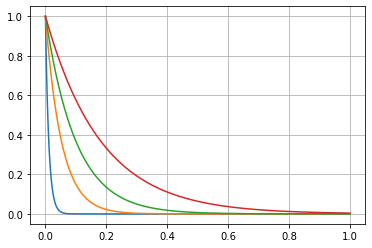

In [4]:
#Effect of radius
time = np.linspace(0, 1, 1000)

plt.figure()
for R in np.array([1.e-6, 5.e-6, 10.e-6, 20.e-6,]):
    plt.plot(time, S(fluid='water', r=R, geom='sphere', T2b=1, rho = 30.e-6, t=time, normed=True))

plt.grid()

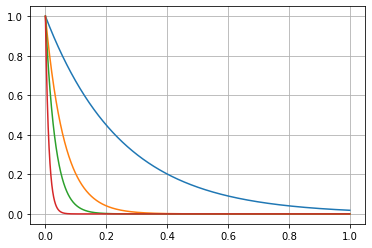

In [5]:
#Effect of surface relaxivity
t = np.linspace(0, 1, 1000)

for R in np.array([1.e-6, 5.e-6, 10.e-6, 30.e-6,]):
    plt.plot(t, S(fluid='water', r=1.e-6, geom='sphere', T2b=1, rho = R, t=t, normed=True))
    
plt.grid()

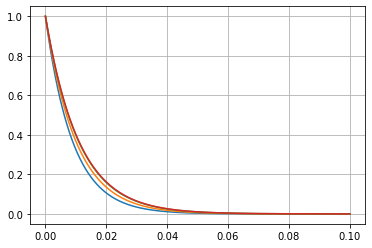

In [6]:
#Effect of T2_bulk
t  = np.linspace(0, 0.1, 1000)

plt.figure()
for Tb in np.array([0.045, 0.1, 0.5, 1]):
    plt.plot(t, S(fluid='water', r=1.e-6, geom='sphere', T2b=Tb, rho = 30.e-6, t=t, normed=True))

plt.grid()

In [128]:
def W(sample, distribution):
    min_radius = sample.min()
    max_radius = sample.max()
    radius_values = np.linspace(min_radius, max_radius, num=np.size(sample))
    W_radius = distribution.pdf(x=radius_values)
    return radius_values, W_radius

In [152]:
def SignalTotal(t, r, distribution_, T2b=1., rho=30.e-6, normed=False):
    
    signal = np.zeros(t.size)
    
    for R in r:
        signal += W(sample=R, distribution=distribution_)[1]*S(B_0=0.05, Temp=303.15, fluid='water', 
                                                            r=R, a=1, b=1, c=1, geom='sphere', 
                                                            T2b=T2b, rho=rho, 
                                                            t=t, normed=False)

    #Normalize results data
    def normalize_results(data):
        data_max = np.max(np.abs(data))
        norm_data = data/data_max
        return norm_data
        
    if not normed:
        return signal
    else:
        return normalize_results(signal)

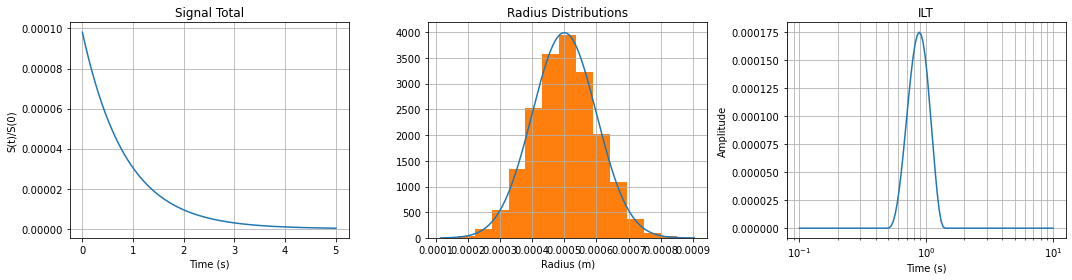

In [199]:
#Pore size distribution
mean_ = 500.e-6 
std_ = 100.e-6
radius_distribution = norm(loc=mean_, scale=std_)
radius_sample = radius_distribution.rvs(size=10000)

rad_values, probabilities_radius = W(radius_sample, radius_distribution)

time = np.linspace(0., 5., 10000)

#Signal
signal_total_1 = SignalTotal(t=time, r=radius_sample, distribution_=radius_distribution, T2b=1., rho=30.e-6, normed=False)

#ILT
bound = np.array([1.e-1, 1.e1])
Nz = 128
alpha = 1

z_results, fs_results, res_lsq, res_reg = ilt(time, signal_total_1, bound, Nz, alpha, normed=False)

#Plot
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(time, signal_total_1)
plt.title('Signal Total')
plt.xlabel('Time (s)')
plt.ylabel('S(t)/S(0)')
plt.grid(True, 'both')

plt.subplot(1, 3, 2)
plt.plot(rad_values, probabilities_radius)
plt.hist(radius_sample, bins='sturges', density=True)
plt.title('Radius Distributions')
plt.xlabel('Radius (m)')
plt.grid(True, 'both')

plt.subplot(1, 3, 3)
plt.plot(1/z_results, fs_results)
plt.xscale('log')
plt.title('ILT')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True, 'both')

plt.tight_layout()
plt.show()

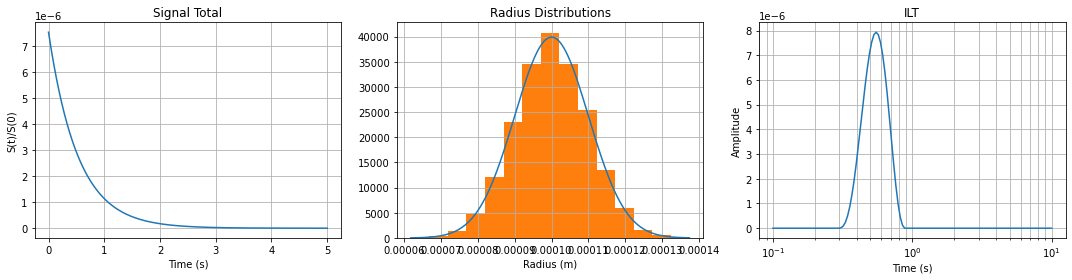

In [198]:
#Pore size distribution
mean_ = 100.e-6 
std_ = 10.e-6
radius_distribution = norm(loc=mean_, scale=std_)
radius_sample = radius_distribution.rvs(size=10000)

rad_values, probabilities_radius = W(radius_sample, radius_distribution)

time = np.linspace(0., 5., 10000)

#Signal
signal_total_1 = SignalTotal(t=time, r=radius_sample, distribution_=radius_distribution, T2b=1., rho=30.e-6, normed=False)

#ILT
bound = np.array([1.e-1, 1.e1])
Nz = 128
alpha = 1

z_results, fs_results, res_lsq, res_reg = ilt(time, signal_total_1, bound, Nz, alpha, normed=False)

#Plot
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(time, signal_total_1)
plt.title('Signal Total')
plt.xlabel('Time (s)')
plt.ylabel('S(t)/S(0)')
plt.grid(True, 'both')

plt.subplot(1, 3, 2)
plt.plot(rad_values, probabilities_radius)
plt.hist(radius_sample, bins='sturges', density=True)
plt.title('Radius Distributions')
plt.xlabel('Radius (m)')
plt.grid(True, 'both')

plt.subplot(1, 3, 3)
plt.plot(1/z_results, fs_results)
plt.xscale('log')
plt.title('ILT')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True, 'both')

plt.tight_layout()
plt.show()

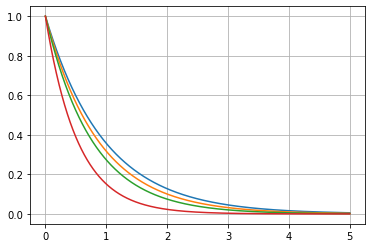

In [170]:
plt.figure()
for r11 in np.array([1.e-6, 5.e-6, 10.e-6, 30.e-6,]):
    signal_total_11 = SignalTotal(t=time, r=radius_sample, distribution_=radius_distribution, T2b=1., rho=r11, normed=True)
    plt.plot(time, signal_total_11)

plt.grid()